In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import xarray as xr
import hvplot.xarray
import geoviews as gv
import geoviews.feature as gf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import xopr.opr_access as xopr

In [17]:
# Establish an OPR session
# The purpose of this right now is just to define a local cache directory, but 
# in the future we might use it to determine which STAC catalog to use or something.
opr = xopr.OPRConnection(cache_dir="radar_cache")

In [18]:
# Use xopr to query the STAC catalog for radar frames within a bounding box

# TODO: Placeholder. No STAC catalog yet.

In [19]:
# Placeholder for loading data

urls = [f"https://data.cresis.ku.edu/data/rds/2022_Antarctica_BaslerMKB/CSARP_standard/20221210_01/Data_20221210_01_{i:03d}.mat" for i in range(1, 10)]

frames = [opr.load_frame(url) for url in urls]

In [20]:
# Inspect an individual frame
frames[0]

<xarray.Dataset> Size: 702kB
Dimensions:    (slow_time: 54, fast_time: 3115)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 432B 2022-12-10T01:25:44.551052570 ...
  * fast_time  (fast_time) float64 25kB 2e-08 4e-08 6e-08 ... 6.228e-05 6.23e-05
Data variables:
    Bottom     (slow_time) float64 432B ...
    Data       (slow_time, fast_time) float32 673kB ...
    Elevation  (slow_time) float64 432B ...
    Heading    (slow_time) float64 432B ...
    Latitude   (slow_time) float64 432B -76.52 -76.52 -76.52 ... -76.51 -76.51
    Longitude  (slow_time) float64 432B 163.8 163.8 163.8 ... 163.8 163.8 163.8
    Pitch      (slow_time) float64 432B ...
    Roll       (slow_time) float64 432B ...
    Surface    (slow_time) float64 432B ...
Attributes: (12/21)
    file_version:         49
    radiometric_corr_dB:  nan
    file_type:            [ 97 114 114  97 121]
    Conventions:          CF-1.8
    title:                Radar Echogram Data
    institution:          Open Polar Radar (OPR)
    ...                   ...
    time_coverage_end:    2022-12-10T01:35:46.768539667
    season:               2022_Antarctica_BaslerMKB
    segment:              20221210_01
    doi:                  {'10.18738/T8/J38CO5'}
    ror:                  {'00hj54h04'}
    funder_text:          ['This work was supported by the Center for Oldest ...

In [27]:
# Combine the frames into a single xarray Dataset representing the flight line
flight_line = xr.concat(frames, dim='slow_time', combine_attrs='drop_conflicts')
flight_line

<xarray.Dataset> Size: 169MB
Dimensions:    (slow_time: 13499, fast_time: 3115)
Coordinates:
  * slow_time  (slow_time) datetime64[ns] 108kB 2022-12-10T01:25:44.551052570...
  * fast_time  (fast_time) float64 25kB 2e-08 4e-08 6e-08 ... 6.228e-05 6.23e-05
Data variables:
    Bottom     (slow_time) float64 108kB nan nan nan nan nan ... nan nan nan nan
    Data       (slow_time, fast_time) float32 168MB 4.712e-09 ... 3.988e-17
    Elevation  (slow_time) float64 108kB 540.5 540.6 ... 2.653e+03 2.653e+03
    Heading    (slow_time) float64 108kB -0.5557 -0.5558 ... -0.4211 -0.4219
    Latitude   (slow_time) float64 108kB -76.52 -76.52 -76.52 ... -76.29 -76.29
    Longitude  (slow_time) float64 108kB 163.8 163.8 163.8 ... 156.7 156.7 156.7
    Pitch      (slow_time) float64 108kB 0.01242 0.01242 ... 0.009197 0.008738
    Roll       (slow_time) float64 108kB 0.02079 0.02079 ... -0.01788 -0.01735
    Surface    (slow_time) float64 108kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/14)
    file_version:         49
    radiometric_corr_dB:  nan
    file_type:            [ 97 114 114  97 121]
    Conventions:          CF-1.8
    title:                Radar Echogram Data
    institution:          Open Polar Radar (OPR)
    ...                   ...
    comment:              Polar radar echogram data with CF-compliant metadata
    season:               2022_Antarctica_BaslerMKB
    segment:              20221210_01
    doi:                  {'10.18738/T8/J38CO5'}
    ror:                  {'00hj54h04'}
    funder_text:          ['This work was supported by the Center for Oldest ...

In [22]:
# Plot a map of where the data was collected with a basemap on an EPSG:3031 projection
proj = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
coords = flight_line[['Longitude', 'Latitude']].to_dataframe().dropna()
(gf.ocean * gf.coastline * gv.Path([coords.values])).opts(projection=proj, aspect='equal')


:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]

In [23]:
stacked = flight_line.Data.rolling(slow_time=10, center=True).mean()
pwr_dB = 10*np.log10(np.abs(stacked))

(3e-05, 0.0)

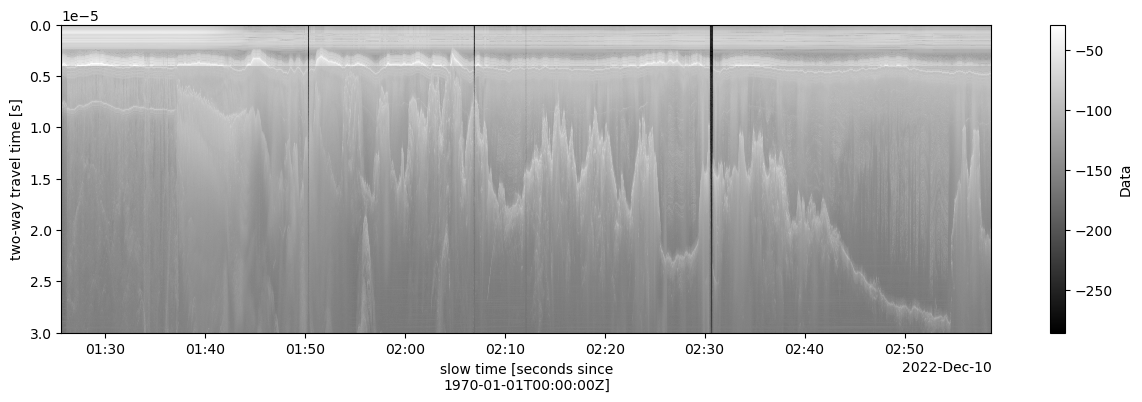

In [24]:
fig, ax = plt.subplots(figsize=(15, 4))
pwr_dB.plot.imshow(x='slow_time', cmap='gray', ax=ax)
ax.invert_yaxis()
ax.set_ylim(3e-5, 0)

In [25]:
# TODO: For some reason, hvplot doesn't want to behave.
#pwr_dB.hvplot.quadmesh(x='slow_time', y='fast_time', cmap='gray', flip_yaxis=True)

In [26]:
print(xopr.generate_citation(flight_line))

This data was collected by The University of Texas at Austin.
Data was processed using the Open Polar Radar (OPR) Toolbox: https://doi.org/10.5281/zenodo.5683959
Please cite the dataset DOI: https://doi.org/{'10.18738/T8/J38CO5'}
Please include the following funder acknowledgment:
['This work was supported by the Center for Oldest Ice Exploration, an NSF Science and Technology Center (NSF 2019719) and the G. Unger Vetlesen Foundation.']

